### Vary bias in data $\mathbf{X}$
Estimate the precision matrix for a fair graph with increasingly biased data.

In [2]:
from utils import *
from opt import *
from time import perf_counter

In [17]:
edge_prob = .1
p = 20
n = 100
g = 2

eps_bias = 1e-3
BIAS_RANGE = np.linspace(0,.5,5)
num_params = len(BIAS_RANGE)

mu1 = .1
mu2 = 100
epsilon = 1e-6
bias_type = 'dp'
eta = .02
iters = 1000

num_trials = 5


In [18]:
bias_true = np.zeros((num_trials,num_params))
bias_bias = np.zeros((num_trials,num_params))

frob_err_glasso = np.zeros((num_trials,num_params))
f1_score_glasso = np.zeros((num_trials,num_params))
time_run_glasso = np.zeros((num_trials,num_params))
bias_glasso = np.zeros((num_trials,num_params))

frob_err_dp = np.zeros((num_trials,num_params))
f1_score_dp = np.zeros((num_trials,num_params))
time_run_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_err_nodewise = np.zeros((num_trials,num_params))
f1_score_nodewise = np.zeros((num_trials,num_params))
time_run_nodewise = np.zeros((num_trials,num_params))
bias_nodewise = np.zeros((num_trials,num_params))

for t in range(num_trials):
    A = generate_connected_er(p,edge_prob)
    Sigma, Theta = create_mtp2_cov(A)
    Theta_od = Theta*(1-np.eye(p))
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    z = np.ones(p, dtype=int)
    z[:int(p/2)] = 0
    Z = np.eye(g)[z].T

    mask_Z = [[(Z[a][:,None]*Z[b][None])*(1-np.eye(p)) for b in range(g)] for a in range(g)]
    ccalZ = [[np.where(mask_Z[a][b]==1) for b in range(g)] for a in range(g)]

    B = np.mean(np.diag(Theta))*np.ones_like(Theta)
    for a in range(g):
        for b in range(g):
            B[ccalZ[a][b]] = eps_bias-1 if a==b else -eps_bias
    while np.min(np.linalg.eigh(B)[0]) < 0:
        B[np.eye(p)==0] *= .99

    for i,lmbda in enumerate(BIAS_RANGE):
        print(f"Bias level: {lmbda:.4f} | Trial {t+1} of {num_trials}")

        bias_true[t,i] = compute_dp2(Theta,Z)

        Theta_bias = (1-lmbda)*Theta + lmbda*B
        Sigma_bias = np.linalg.inv(Theta_bias)
        X_bias = np.random.multivariate_normal(np.zeros(p), Sigma_bias, n)
        Sigma_bias_hat = X_bias.T@X_bias/n
        bias_bias[t,i] = compute_dp2(Theta_bias,Z)

        tic = perf_counter()
        Theta_glasso = node_FGL_fista(Sigma_bias_hat, mu1, eta, 0, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_glasso[t,i] = compute_frob_err(Theta_glasso, Theta)
        f1_score_glasso[t,i] = compute_f1_score(Theta_glasso, Theta,.1)
        time_run_glasso[t,i] = np.abs(toc-tic)
        bias_glasso[t,i] = compute_dp2(Theta_glasso, Z)
        print( '    ' +
            'GLASSO: ' + 
            f'Err: {frob_err_glasso[t,i]:.4f} | ' +
            f'F1: {f1_score_glasso[t,i]:.4f} | ' +
            f'Time: {time_run_glasso[t,i]:.4f} | ' +
            f'Bias: {bias_glasso[t,i]:.4f} - {bias_true[t,i]:.4f}')

        tic = perf_counter()
        Theta_dp = node_FGL_fista(Sigma_bias_hat, mu1, eta, mu2, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_dp[t,i] = compute_frob_err(Theta_dp, Theta)
        f1_score_dp[t,i] = compute_f1_score(Theta_dp, Theta,.1)
        time_run_dp[t,i] = np.abs(toc-tic)
        bias_dp[t,i] = compute_dp2(Theta_dp, Z)
        print( '    ' +
            'DP:     ' + 
            f'Err: {frob_err_dp[t,i]:.4f} | ' +
            f'F1: {f1_score_dp[t,i]:.4f} | ' +
            f'Time: {time_run_dp[t,i]:.4f} | ' +
            f'Bias: {bias_dp[t,i]:.4f} - {bias_true[t,i]:.4f}')

        tic = perf_counter()
        Theta_nodewise = node_FGL_fista(Sigma_bias_hat, mu1, eta, mu2, Z, 'nodewise', epsilon, iters, False)
        toc = perf_counter()
        frob_err_nodewise[t,i] = compute_frob_err(Theta_nodewise, Theta)
        f1_score_nodewise[t,i] = compute_f1_score(Theta_nodewise, Theta,.1)
        time_run_nodewise[t,i] = np.abs(toc-tic)
        bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z)
        print( '    ' +
            'Nw. DP: ' + 
            f'Err: {frob_err_nodewise[t,i]:.4f} | ' +
            f'F1: {f1_score_nodewise[t,i]:.4f} | ' +
            f'Time: {time_run_nodewise[t,i]:.4f} | ' +
            f'Bias: {bias_nodewise[t,i]:.4f} - {bias_true[t,i]:.4f}')



Bias level: 0.0000 | Trial 1 of 5
    GLASSO: Err: 0.0964 | F1: 0.4167 | Time: 0.2296 | Bias: 0.0000 - 0.0003
    DP:     Err: 0.0964 | F1: 0.4167 | Time: 0.1866 | Bias: 0.0000 - 0.0003
    Nw. DP: Err: 0.0964 | F1: 0.4167 | Time: 1.1767 | Bias: 0.0000 - 0.0003
Bias level: 0.1250 | Trial 1 of 5
    GLASSO: Err: 0.0924 | F1: 0.4167 | Time: 0.2021 | Bias: 0.0000 - 0.0003
    DP:     Err: 0.0924 | F1: 0.4167 | Time: 0.2111 | Bias: 0.0000 - 0.0003
    Nw. DP: Err: 0.0924 | F1: 0.4167 | Time: 1.2715 | Bias: 0.0000 - 0.0003
Bias level: 0.2500 | Trial 1 of 5
    GLASSO: Err: 0.0911 | F1: 0.4167 | Time: 0.2034 | Bias: 0.0000 - 0.0003
    DP:     Err: 0.0911 | F1: 0.4167 | Time: 0.1887 | Bias: 0.0000 - 0.0003
    Nw. DP: Err: 0.0911 | F1: 0.4167 | Time: 1.1708 | Bias: 0.0000 - 0.0003
Bias level: 0.3750 | Trial 1 of 5
    GLASSO: Err: 0.1125 | F1: 0.4167 | Time: 0.2138 | Bias: 0.0000 - 0.0003
    DP:     Err: 0.1125 | F1: 0.4167 | Time: 0.2078 | Bias: 0.0000 - 0.0003
    Nw. DP: Err: 0.1125 | F1

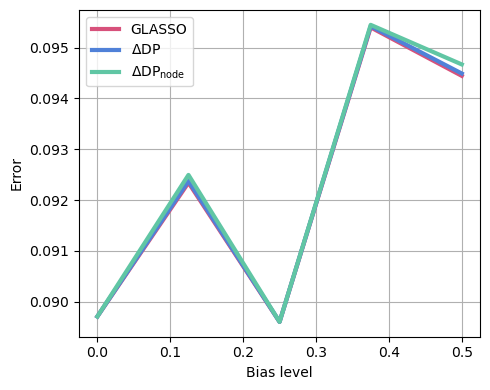

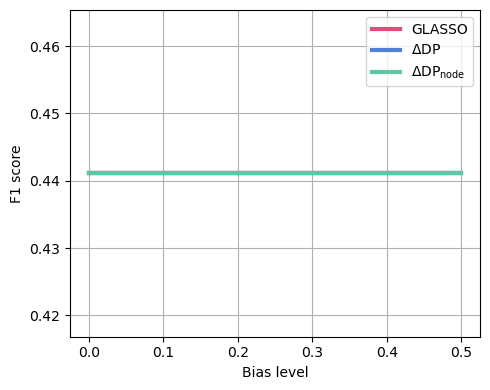

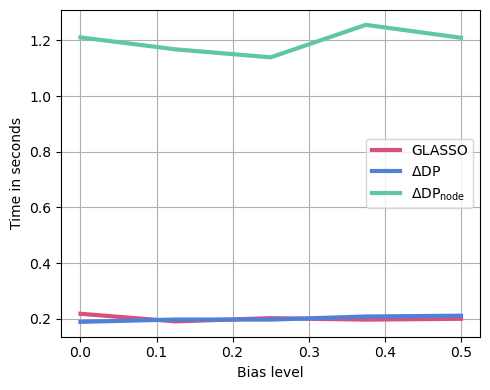

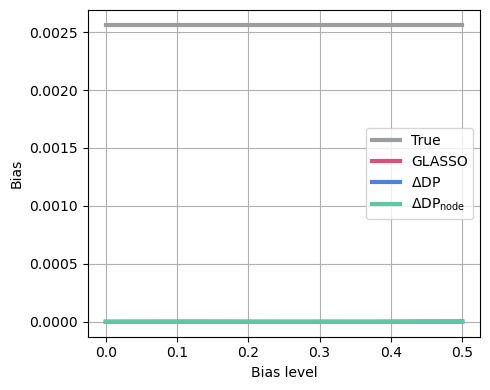

In [19]:
x_label = r'Bias level'
x_range = BIAS_RANGE

plt_args = { 'linewidth':3 }

y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = frob_err_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = frob_err_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = frob_err_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



y_label = 'F1 score'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = f1_score_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = f1_score_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = f1_score_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Time in seconds'
y_range = time_run_glasso.mean(0)
clr = greens[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = time_run_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = time_run_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = time_run_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = bias_true.mean(0)
ax.plot(x_range, y_range, c=grays[10], **plt_args, label='True')

y_range = bias_glasso.mean(0)
# y_range = bias_glasso.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = bias_dp.mean(0)
# y_range = bias_dp.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = bias_nodewise.mean(0)
# y_range = bias_nodewise.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


